# First Look at AuxTel Data
Originally written by Alex Broughton

In [1]:
! eups list -s | grep lsst_distrib
! eups list -s | grep cp_pipe
! eups list -s | grep ip_isr

lsst_distrib          g4213664e8e+995cec829e 	w_2023_29 setup
cp_pipe               LOCAL:/sdf/home/a/abrought/alternate_branches/dm_stack/cp_pipe 	setup
ip_isr                LOCAL:/sdf/home/a/abrought/alternate_branches/dm_stack/ip_isr 	setup


In this notebook, we will explore how to use the data butler to access sky data from the LATISS instrument on AuxTel. As an example, we will fit the dependence of BF effect on color using on-sky data. We will learn how to access, reduce, and model the data using the data Butler attatched to USDF's $\texttt{/repo/embargo}$. The data is based on AuxTel data from the night of 2023-08-03/17/29.

You can find the most recent data here:
$\texttt{https://roundtable.lsst.codes/rubintv/summit/auxtel/historical/2023-08-03}$




In [2]:
# Generic imports
import os
import numpy as np
import glob
from astropy.io import fits
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
from lsst.obs.lsst import Latiss
camera = Latiss().getCamera()
from matplotlib.pyplot import cm
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker


##### First, I'll setup the space and define some utility functions that will be useful down the line.

In [3]:
def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')

def get_astropy_wcs(image, verbose=False):
    """
    Get an astropy WCS object from an lsst.afw.image metadata WCS format
    
    Parameters
    ----------
    image: lsst.afw.image._exposure.ExposureF
        Input image with Fits Stadard WCS metadata

    Returns
    -------
    wcs: astropy.wcs.wcs.WCS
        Astropy WCS for the image object.
    """
    
    from astropy.wcs import WCS

    if verbose:
        print(image.getWcs())
    
    wcs_dict = dict()
    for val in image.getWcs().getFitsMetadata():
        wcs_dict[str(val)] = image.getWcs().getFitsMetadata()[str(val)]

    return WCS(wcs_dict)

def get_astropy_wcs_from_image_file(image_fits):
    """
    Get an astropy WCS object from an image fits file which contains 
    lsst.afw.image 
    
    Parameters
    ----------
    image: lsst.afw.image._exposure.ExposureF
        Input image with Fits Stadard WCS metadata

    Returns
    -------
    wcs: astropy.wcs.wcs.WCS
        Astropy WCS for the image object.
    """
    from astropy.wcs import WCS
    hdu = fits.open(image_fits)
    wcs = WCS(hdu['SkyWcs'].header)
    hdu.close()
    
    return wcs
    

def find_stars_on_sky(image):
    """
    Will identify all 5 sigma sources in an image and return a catalog
    of the star parameters. Uses DAOStarFinder (Stetson 1987; PASP 99, 191).
    
    Parameters
    ----------
    image: lsst.afw.image._exposure.ExposureF
        Input image with Fits Stadard WCS metadata

    Returns
    -------
    catalog: astropy.table.Table
        Astropy table of star-like objects
    """

    from astropy.stats import sigma_clipped_stats
    from photutils.datasets import load_star_image
    from photutils.detection import DAOStarFinder
    from astropy.wcs import WCS

    data = image.getImage().getArray()
    wcs = get_astropy_wcs(image)
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)   

    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
    sources = daofind(data - median)  

    for col in sources.colnames:  
        if col not in ('id', 'npix'):
            sources[col].info.format = '%.2f'  # for consistent table output

    sky_coords = [wcs.pixel_to_world(source['xcentroid'], source['ycentroid']).transform_to('galactic') for source in sources]
    
    sources.add_columns([[c.l for c in sky_coords], [c.b for c in sky_coords]], names=['l (deg)', 'b (deg)'])
    
    #sources.pprint(max_width=76)  
    
    return sources 


def get_2nd_mom_from_hsm_result(results):
    """
    Calculate second moments from HSM adative moment result
    derived by galsim HSM module (ShapeData object). 
    """
    e1 = results.observed_shape.e1
    e2 = results.observed_shape.e2
    sigma = results.moments_sigma
    sigma_ave = sigma / (1 - e1**2 - e2**2 )**(0.25) 
    Ixx = (1+e1) * sigma_ave**2
    Iyy = (1-e1) * sigma_ave**2
    Ixy = e2 * (sigma_ave**2) 
    
    return Ixx, Iyy, Ixy


def get_star_stats(stars,image, ind, showSpot=True):
    """ 
    Derive photometry for a source in an image using a
    re-implementation of the HSM algorithm in galsim.
    
    Parameters
    ----------
    stars: arbitrary table type
        Initial catalog of stars with something like 'x/ycentroid'
        or 'base_SdssCentroid_y'
    image: lsst.afw.image._exposure.ExposureF
        Input image with Fits Stadard WCS metadata
    ind: int
       Index of star in the catalog to compute statistics on.
    showSpot: int
       Display a stamp image of the star.

    Returns
    -------
    stamp: numpy.ndarray
        Stamp around the selected star
    result: galsim ShapeData object
        HSM adaptive moment result on the selected star

    """
    import galsim
    
    #image = imageobj.getImage().getArray()
    
    result = np.zeros((1, 4))
    star = stars[ind]

    (x,y) = (0,0)
    if 'xcentroid' in stars.columns:
        y = star['xcentroid']
        x = star['ycentroid']
    else:
        y = star['base_SdssCentroid_x']
        x = star['base_SdssCentroid_y']

    #r = np.sqrt(star['npix']/np.pi)
    s = 40

    xmin = int(max(0,x-s))
    xmax = int(min(image.shape[0]-1, x+s+1))
    ymin = int(max(0,y-s))
    ymax = int(min(image.shape[1]-1, y+s+1))
    stamp = galsim.Image(image[xmin:xmax,ymin:ymax])

    if showSpot:
        plt.imshow(image[xmin:xmax,ymin:ymax])

    try:
        res = galsim.hsm.FindAdaptiveMom(stamp)
        ixx,iyy,ixy = get_2nd_mom_from_hsm_result(res)
        result = [np.max(image[xmin:xmax,ymin:ymax]),ixx,iyy,ixy,res.moments_sigma,res.moments_amp]
    except:
        result = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
        
    
    return stamp.array,result

def loader(i, size, scaled=False):
    """ 
    Fun little function to be placed inside a loop to display a 
    progress bar when looping over many objects.

    Usage:
    for i in range(len(arr)):
        loader(i,len(arr))
        ...
        

    Parameters
    ----------
    i: int 
        Current index
    size: int
        Total size of the array being looped over.
    scaled: bool
        Whether to dispay a fixed length progress bar of 100 points (False),
        or display a progress bar that is the length of the array (True).

    """
    load = "." * int(((i+1)/size)*100)
    load_ext = " " * (100 - len(load))
    
    if scaled:
        load = "." * (i+1)
        load_ext = " " * (size - i - 1)

    print("[" + load + load_ext + "] " + f"{i+1}/{size} ({round((i+1) / size * 100., 0)}%)", end='\r')

    return 
    

First we are going to setup a butler to repository where the LATISS data is ingested on USDF ($\texttt{/repo/embargo}$). It normally takes 1-2 days after data is taken for it to be accessible from a butler repository.

You can process your own raw data into collections, or you can look at the Data Reduction Pipeline (DRP) processed images which should already be available to you. The DRP collections contain fully caliobrated images and tables of objects using the most up-to-date calibrations, and we will use those here.

Let's query all the collections that were processed with the most recent weekly release of the LSST Science Pipelines (w_2023_33):

In [4]:
repo = "/repo/embargo"
butler = Butler(repo)
registry = butler.registry

collections = []
for c in registry.queryCollections("LATISS/runs/AUXTEL_DRP_IMAGING*w_2023_33*"):
    collections.append(c)
    print(c) 

LATISS/runs/AUXTEL_DRP_IMAGING_2023-08A-07AB-05AB/w_2023_33/PREOPS-3613/20230821T153036Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-08A-07AB-05AB/w_2023_33/PREOPS-3613
LATISS/runs/AUXTEL_DRP_IMAGING_2023-08A-07AB-05AB/w_2023_33/PREOPS-3613/20230822T175428Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-08A-07AB-05AB/w_2023_33/PREOPS-3613/20230823T142229Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-08A-07AB-05AB/w_2023_33/PREOPS-3613/20230828T145332Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-08A-07AB-05AB/w_2023_33/PREOPS-3613/20230828T153937Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-08A-07AB-05AB/w_2023_33/PREOPS-3613/20230825T142344Z


Let's grab a smaller butler which contains a registry of data within just these collections. We will find all exposures that were imaged on or after 8/3/2023 in the SDSS i band and have an associated table of calibrated stars.
<br> The $\texttt{finalized_src_table}$ data type will contain a catalog of calibrated stars. 



In [5]:
subbutler = Butler(repo,collections=collections)
subregistry = subbutler.registry
refs = np.sort(list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='i' AND visit>=2023080300000")))

print(len(refs))

112


We now have a list of references which match specific images (visits in this case) and all their accompanying data products.

You can get any of the data types listed in the DRP pipeline associated with these visits. 

If you want the processed image, you can query postISRCCD or calexp. 
$\texttt{postISRCCD}$ is an image that has been run through ISR but has not been calibrated astrometrically or photometrically or with a PSF model.
It is a temporary intermediate object that will not be part of a release. In the future, $\texttt{calexps}$ will be called $\texttt{pvis}$, or “processed visit images”.
These will have final-final calibrations applied (the calexp has early calibrations). To get $\texttt{calexps}$, you must also pass the detector argument (there is only one sensor on AuxTel and its detector number is 0). If you want a $\texttt{postISRCCD}$, you will also need to supply an exposure number, which in this case is the same as the visit number since we are only taking one exposure/vist.

Example:

In [6]:
refs[0].dataId

{instrument: 'LATISS', visit: 2023080300277, ...}

In [7]:
stars = subbutler.get('finalized_src_table', dataId = refs[0].dataId, collections=collections)
print(stars.columns)

Index(['id', 'coord_ra', 'coord_dec', 'parent', 'base_SdssCentroid_x',
       'slot_Centroid_x', 'base_SdssCentroid_y', 'slot_Centroid_y',
       'base_SdssCentroid_flag', 'base_GaussianFlux_flag_badCentroid',
       ...
       'modelfit_CModel_exp_apCorrErr', 'slot_ModelFlux_exp_apCorrErr',
       'modelfit_CModel_exp_flag_apCorr', 'slot_ModelFlux_exp_flag_apCorr',
       'modelfit_CModel_initial_apCorr', 'slot_ModelFlux_initial_apCorr',
       'modelfit_CModel_initial_apCorrErr', 'slot_ModelFlux_initial_apCorrErr',
       'modelfit_CModel_initial_flag_apCorr',
       'slot_ModelFlux_initial_flag_apCorr'],
      dtype='object', length=755)


In [8]:
for c in stars.columns:
    print(c)

id
coord_ra
coord_dec
parent
base_SdssCentroid_x
slot_Centroid_x
base_SdssCentroid_y
slot_Centroid_y
base_SdssCentroid_flag
base_GaussianFlux_flag_badCentroid
base_PsfFlux_flag_badCentroid
ext_convolved_ConvolvedFlux_0_flag_badCentroid
ext_convolved_ConvolvedFlux_1_flag_badCentroid
ext_convolved_ConvolvedFlux_2_flag_badCentroid
ext_convolved_ConvolvedFlux_3_flag_badCentroid
ext_convolved_ConvolvedFlux_flag_badCentroid
ext_photometryKron_KronFlux_flag_badInitialCentroid
ext_shapeHSM_HsmPsfMoments_flag_badCentroid
ext_shapeHSM_HsmShapeRegauss_flag_badCentroid
ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid
ext_shapeHSM_HsmSourceMoments_flag_badCentroid
modelfit_DoubleShapeletPsfApprox_flag_badCentroid
slot_Centroid_flag
base_SdssCentroid_flag_edge
base_GaussianFlux_flag_badCentroid_edge
base_PsfFlux_flag_badCentroid_edge
ext_convolved_ConvolvedFlux_0_flag_badCentroid_edge
ext_convolved_ConvolvedFlux_1_flag_badCentroid_edge
ext_convolved_ConvolvedFlux_2_flag_badCentroid_edge
ext_convo

In [9]:
image = subbutler.get('calexp', dataId = refs[0].dataId, detector=0,collections=collections)

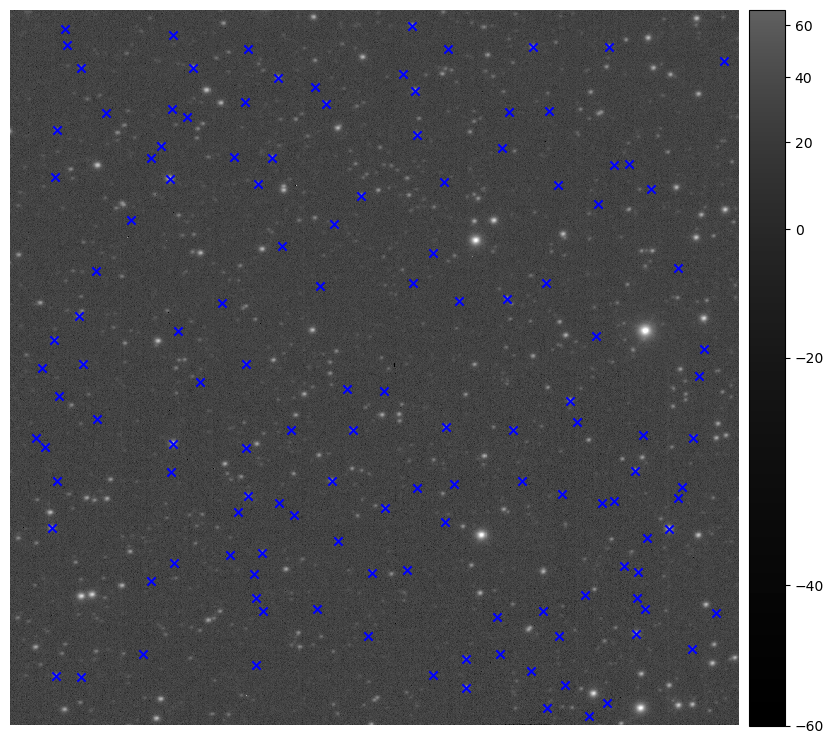

In [10]:
display(image)
plt.scatter(stars['base_SdssCentroid_x'],stars['base_SdssCentroid_y'], marker="x", color="blue")

Let's get a data from g, r, and i bands

In [11]:
%%time
refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='i' AND visit>=2023080300000")) 
data_list = []
for i, ref in enumerate(refs):
    data_list.append(subbutler.get('finalized_src_table', dataId = ref.dataId, collections=collections))
data_i = pd.concat(data_list)
del data_list

refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='r' AND visit>=2023080300000")) 
data_list = []
for i, ref in enumerate(refs):
    data_list.append(subbutler.get('finalized_src_table', dataId = ref.dataId, collections=collections))
data_r = pd.concat(data_list)
del data_list

refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='g' AND visit>=2023080300000")) 
data_list = []
for i, ref in enumerate(refs):
    data_list.append(subbutler.get('finalized_src_table', dataId = ref.dataId, collections=collections))
data_g = pd.concat(data_list)
del data_list

CPU times: user 24.6 s, sys: 1.37 s, total: 26 s
Wall time: 43.1 s


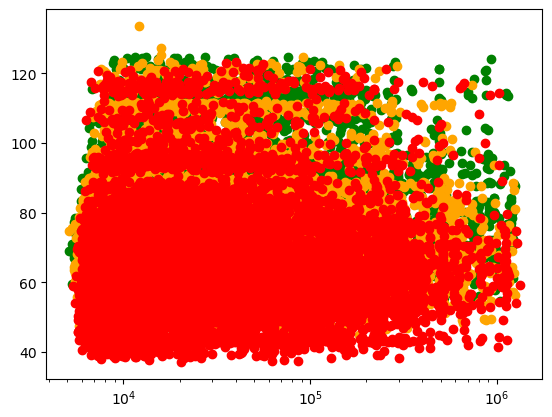

In [12]:
plt.scatter(data_g['slot_ApFlux_instFlux'], data_g['slot_PsfShape_xx'] + data_g['slot_PsfShape_yy'], color="g")
plt.scatter(data_r['slot_ApFlux_instFlux'], data_r['slot_PsfShape_xx'] + data_r['slot_PsfShape_yy'], color="orange")
plt.scatter(data_i['slot_ApFlux_instFlux'], data_i['slot_PsfShape_xx'] + data_i['slot_PsfShape_yy'], color="red")
#plt.ylim(-10,85)
plt.xscale('log')

In [13]:
def linear(x, alpha, beta, gamma, c):
    return alpha * x + beta*c + gamma

In [14]:
mask = np.isfinite(data_r['slot_PsfShape_xx'])
data_r = data_r[mask]

In [15]:
from scipy.optimize import curve_fit



poptg, ppcovg = curve_fit(linear, data_g['slot_ApFlux_instFlux'], data_g['slot_PsfShape_xx'], bounds=([-np.inf,-np.inf,20.,0.3],[np.inf,np.inf,60.,1.1]))
poptr, ppcovr = curve_fit(linear, data_r['slot_ApFlux_instFlux'], data_r['slot_PsfShape_xx'], bounds=([-np.inf,-np.inf,20.,1.0],[np.inf,np.inf,60.,2.0]))
popti, ppcovi = curve_fit(linear, data_i['slot_ApFlux_instFlux'], data_i['slot_PsfShape_xx'], bounds=([-np.inf,-np.inf,20.,0.0],[np.inf,np.inf,60.,1.0]))





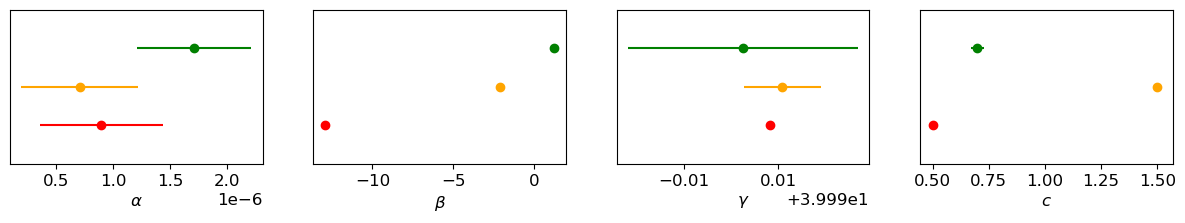

In [16]:

plt.rcParams.update({'font.size': 12})
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(15,2)) 
ax1.errorbar([poptg[0]], [3.0], xerr=[np.sqrt(ppcovg[0][0])], marker="o", color="g")
ax1.errorbar([poptr[0]], [2.0], xerr=[np.sqrt(ppcovr[0][0])], marker="o", color="orange")
ax1.errorbar([popti[0]], [1.0], xerr=[np.sqrt(ppcovi[0][0])], marker="o", color="red")

ax2.errorbar([poptg[1]], [3.0], xerr=[np.sqrt(ppcovg[1][1])], marker="o", color="g")
ax2.errorbar([poptr[1]], [2.0], xerr=[np.sqrt(ppcovr[1][1])], marker="o", color="orange")
ax2.errorbar([popti[1]], [1.0], xerr=[np.sqrt(ppcovi[1][1])], marker="o", color="red")

ax3.errorbar([poptg[2]], [3.0], xerr=[np.sqrt(ppcovg[2][2])], marker="o", color="g")
ax3.errorbar([poptr[2]], [2.0], xerr=[np.sqrt(ppcovr[2][2])], marker="o", color="orange")
ax3.errorbar([popti[2]], [1.0], xerr=[np.sqrt(ppcovi[2][2])], marker="o", color="red")

ax4.errorbar([poptg[3]], [3.0], xerr=[np.sqrt(ppcovg[3][3])], marker="o", color="g")
ax4.errorbar([poptr[3]], [2.0], xerr=[np.sqrt(ppcovr[3][3])], marker="o", color="orange")
ax4.errorbar([popti[3]], [1.0], xerr=[np.sqrt(ppcovi[3][3])], marker="o", color="red")

ax1.set_ylim(0,4)
ax2.set_ylim(0,4)
ax3.set_ylim(0,4)
ax4.set_ylim(0,4)

ax1.set_xlabel(r"$\alpha$")
ax2.set_xlabel(r"$\beta$")
ax3.set_xlabel(r"$\gamma$")
ax4.set_xlabel(r"$c$")

ax1.get_yaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)




In [17]:
refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='i' AND visit>=2023080300000")) 
data_list_i = []
for i, ref in enumerate(refs):
    data = subbutler.get('finalized_src_table', dataId = ref.dataId, collections=collections)
    data_list_i.append(len(data))

refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='r' AND visit>=2023080300000")) 
data_list_r = []
for i, ref in enumerate(refs):
    data = subbutler.get('finalized_src_table', dataId = ref.dataId, collections=collections)
    data_list_r.append(len(data))

refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='g' AND visit>=2023080300000")) 
data_list_g = []
for i, ref in enumerate(refs):
    data = subbutler.get('finalized_src_table', dataId = ref.dataId, collections=collections)
    data_list_g.append(len(data))

In [88]:
print(image.getMetadata())

CCD_MANU = "ITL"
// CCD Manufacturer
CCD_TYPE = "3800C"
// CCD Model Number
DETSIZE = "[1:4072,1:4000]"
BINX = 1
// [pixels] binning along X axis
BINY = 1
// [pixels] binning along Y axis
CCDGAIN = 1.0000000000000
// Rough guess at overall system gain (e-/DNB)
CCDNOISE = 10.000000000000
// Rough guess at system noise (e- rms)
CCDSLOT = "S00"
// The CCD Slot
RAFTBAY = "R00"
// The RAFT Bay
FIRMWARE = "11384004"
// DAQ firmware version (Hex)
PLATFORM = "auxtel"
// DAQ platform version
CONTNUM = "189216ee"
// REB serial # (Hex)
DAQVERS = "R5-V6.7 2023-06-22T07:15:56Z (113ce6c8)"
// DAQ version
DAQPART = "lat"
// DAQ partition
DAQFOLD = "raw"
// DAQ folder the image was initially created in
SEQFILE = "FP_ITL_2s_ir2_v26_no_RG.seq"
// Sequencer file name
SEQNAME = "FP_ITL_2s_ir2_v26_no_RG.seq"
// Sequencer file name
SEQCKSUM = "1477162166"
// Checksum of Sequencer
LSST_NUM = "ITL-3800C-068"
// LSST Assigned CCD Number
CCD_SERN = "20862"
// Manufacturers? CCD Serial Number
REBNAME = "Unknown"

In [ ]:
import galsim
    
def get_stars(data, img):
    image = img.getImage().getArray()
    results = np.full((len(data), 10), np.nan)
    for i in range(len(data)):
        star = data.iloc[i]
        result = np.full((1, 12), np.nan)

        y = star['base_SdssCentroid_x']
        x = star['base_SdssCentroid_y']

        s = 25

        xmin = int(max(0,x-s))
        xmax = int(min(image.shape[0]-1, x+s+1))
        ymin = int(max(0,y-s))
        ymax = int(min(image.shape[1]-1, y+s+1))
        stamp = galsim.Image(image[xmin:xmax,ymin:ymax])

        try:
            res = galsim.hsm.FindAdaptiveMom(stamp)
            ixx,iyy,ixy = get_2nd_mom_from_hsm_result(res)
            result = [ixx,iyy,ixy,np.max(image[xmin:xmax,ymin:ymax]),res.moments_sigma,res.moments_amp,x,y,res.observed_shape.e1,res.observed_shape.e1]
        except:
            continue
        
        results[i] = result
        
    return results
        
        
refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='i' AND visit>=2023080300000")) 
full_data_i = np.full((1,11),np.nan)
for i, ref in enumerate(refs):
    loader(i,len(refs))
    data = subbutler.get('finalized_src_table', dataId = ref.dataId, collections=collections)
    image = subbutler.get('calexp', dataId = ref.dataId, detector=0, exposure=ref.dataId['visit'], collections=collections)
    results = get_stars(data, image)
    #print(results.shape, np.asarray([times]).T.shape)
    times = np.asarray([image.getMetadata()['MJD']]*len(results))
    results = np.concatenate((results,np.asarray([times]).T),axis=1)
    full_data_i = np.vstack((full_data_i,results))

In [ ]:
%%time
refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='r' AND visit>=2023080300000")) 
full_data_r = np.full((1,11),np.nan)
for i, ref in enumerate(refs):
    loader(i,len(refs))
    data = subbutler.get('finalized_src_table', dataId = ref.dataId, collections=collections)
    image = subbutler.get('calexp', dataId = ref.dataId, detector=0, exposure=ref.dataId['visit'], collections=collections)
    results = get_stars(data, image)
    #print(results.shape, np.asarray([times]).T.shape)
    times = np.asarray([image.getMetadata()['MJD']]*len(results))
    results = np.concatenate((results,np.asarray([times]).T),axis=1)
    full_data_r = np.vstack((full_data_r,results))

In [ ]:
%%time
refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=collections, where="band='g' AND visit>=2023080300000")) 
full_data_g = np.full((1,11),np.nan)
for i, ref in enumerate(refs):
    loader(i,len(refs))
    data = subbutler.get('finalized_src_table', dataId = ref.dataId, collections=collections)
    image = subbutler.get('calexp', dataId = ref.dataId, detector=0, exposure=ref.dataId['visit'], collections=collections)
    results = get_stars(data, image)
    #print(results.shape, np.asarray([times]).T.shape)
    times = np.asarray([image.getMetadata()['MJD']]*len(results))
    results = np.concatenate((results,np.asarray([times]).T),axis=1)
    full_data_g = np.vstack((full_data_g,results))

# Seeing vs exposure

In [ ]:
pixscale = 0.0956783 # arcsec/pixel


In [ ]:
fwhm_i = 2*np.sqrt(2*np.log(2)) * full_data_i[:,4] * pixscale
fwhm_r = 2*np.sqrt(2*np.log(2)) * full_data_r[:,4] * pixscale
fwhm_g = 2*np.sqrt(2*np.log(2)) * full_data_g[:,4] * pixscale

In [ ]:
plt.figure()
_ = plt.hist([fwhm_i,fwhm_r,fwhm_g], stacked=True, bins=25, color=['r','orange','g'], label=['$i$','$r$','$g$'], alpha=0.6)
plt.ylabel("$\mathrm{N_{stars}}$/bin", fontsize=15)
plt.xlabel("Star FWHM (arcsec)", fontsize=15)
plt.legend(frameon=False)

In [ ]:
MJDs_i = np.sort(np.unique(full_data_i[:,12]))
seeings_i = []
for mjd in MJDs_i:
    try:
        seeings_i.append(np.mean(fwhm_i[full_data_i[:,12]==mjd]))
    except:
        seeings_i.append(np.nan)
        
MJDs_r = np.sort(np.unique(full_data_r[:,12]))
seeings_r = []
for mjd in MJDs_r:
    try:
        seeings_r.append(np.mean(fwhm_r[full_data_r[:,12]==mjd]))
    except:
        seeings_r.append(np.nan)
        
        
MJDs_g = np.sort(np.unique(full_data_g[:,12]))
seeings_g = []
for mjd in MJDs_g:
    try:
        seeings_g.append(np.mean(fwhm_g[full_data_g[:,12]==mjd]))
    except:
        seeings_g.append(np.nan)

In [ ]:
plt.scatter(MJDs_i, seeings_i, color="r")
plt.scatter(MJDs_r, seeings_r, color="orange")
plt.scatter(MJDs_g, seeings_g, color="g")
plt.ylabel("Mean Seeing per Exp \n FWHM (arcsec)")
plt.xlabel("MJD")

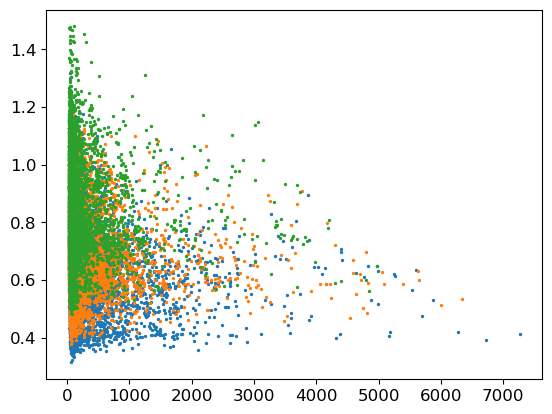

In [80]:
x = full_data_i[:,3]
y = 2*(full_data_i[:,4]*pixscale)**2
mask = (full_data_i[:,10] < 0.15+6.016e4)
plt.scatter(x[mask], y[mask], s=2)

x = full_data_r[:,3]
y = 2*(full_data_r[:,4]*pixscale)**2
mask = (full_data_r[:,10] < 0.15+6.016e4)
plt.scatter(x[mask], y[mask], s=2)

x = full_data_g[:,3]
y = 2*(full_data_g[:,4]*pixscale)**2
mask = (full_data_g[:,10] < 0.15+6.016e4)
plt.scatter(x[mask], y[mask], s=2)




In [81]:
x = full_data_i[:,3]
y = 2*(full_data_i[:,4]*pixscale)**2
mask = (full_data_i[:,10] < 0.15+6.016e4)
poptg, ppcovg = curve_fit(linear, x[mask], y[mask], bounds=([-np.inf,-np.inf,20.,0.3],[np.inf,np.inf,60.,1.1]))


x = full_data_i[:,3]
y = 2*(full_data_i[:,4]*pixscale)**2
mask = (full_data_i[:,10] < 0.15+6.016e4)
poptg, ppcovg = curve_fit(linear, x[mask], y[mask], bounds=([-np.inf,-np.inf,20.,0.3],[np.inf,np.inf,60.,1.1]))


x = full_data_i[:,3]
y = 2*(full_data_i[:,4]*pixscale)**2
mask = (full_data_i[:,10] < 0.15+6.016e4)
poptg, ppcovg = curve_fit(linear, x[mask], y[mask], bounds=([-np.inf,-np.inf,20.,0.3],[np.inf,np.inf,60.,1.1]))

# poptr, ppcovr = curve_fit(linear, data_r['slot_ApFlux_instFlux'], data_r['slot_PsfShape_xx'], bounds=([-np.inf,-np.inf,20.,1.0],[np.inf,np.inf,60.,2.0]))
# popti, ppcovi = curve_fit(linear, data_i['slot_ApFlux_instFlux'], data_i['slot_PsfShape_xx'], bounds=([-np.inf,-np.inf,20.,0.0],[np.inf,np.inf,60.,1.0]))



# Stars per ccd

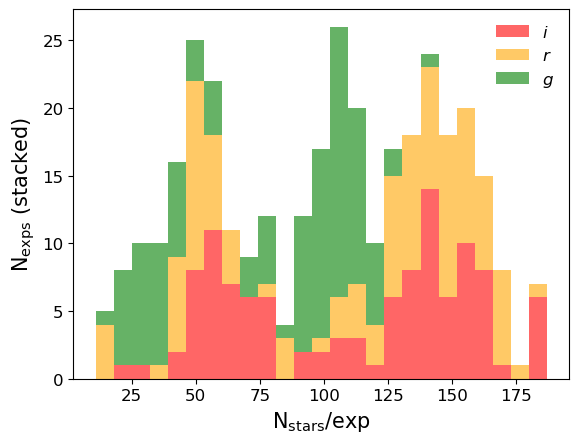

In [27]:
plt.figure()
_ = plt.hist([data_list_i,data_list_r,data_list_g], stacked=True, bins=25, color=['r','orange','g'], label=['$i$','$r$','$g$'], alpha=0.6)
plt.ylabel("$\mathrm{N_{exps}}$ (stacked)", fontsize=15)
plt.xlabel("$\mathrm{N_{stars}}$/exp", fontsize=15)
plt.legend(frameon=False)

In [28]:
np.sum(data_list_i), np.sum(data_list_r), np.sum(data_list_g)

(12454, 13030, 9107)

# PSF Modeling

(0.0, 1.5)

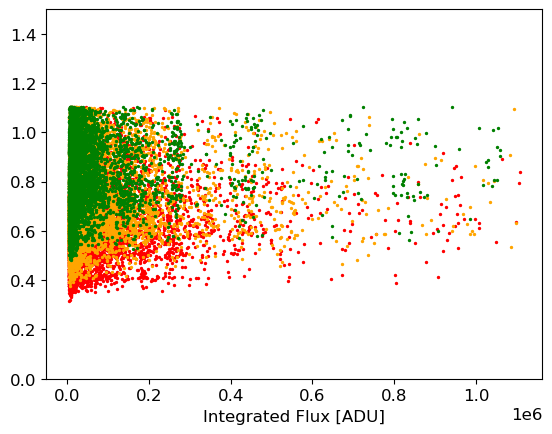

In [49]:
T_PSF = 2 * (full_data_i[:,4]*pixscale)**2
T_model =(full_data_i[:,9] + full_data_i[:,9])*(pixscale**2)
mask = (fwhm_i < 1.75)
plt.scatter(full_data_i[:,5][mask], T_PSF[mask], color="r", s=2)

T_PSF = 2 * (full_data_r[:,4]*pixscale)**2
T_model =(full_data_r[:,9] + full_data_r[:,9])*(pixscale**2)
mask = (fwhm_r < 1.75)
plt.scatter(full_data_r[:,5][mask], T_PSF[mask], color="orange", s=2)

T_PSF = 2 * (full_data_g[:,4]*pixscale)**2
T_model =(full_data_g[:,9] + full_data_g[:,9])*(pixscale**2)
mask = (fwhm_g < 1.75)
plt.scatter(full_data_g[:,5][mask], T_PSF[mask], color="g", s=2)

plt.xlabel("Integrated Flux [ADU]")
plt.ylim(0,1.5)

In [30]:
from scipy.stats import binned_statistic_2d

In [82]:
bins_per_side = 5

range_xy = np.asarray([[0., 4000.], [0., 4000.]])
x = full_data_i[:,6]
y = full_data_i[:,7]
values = full_data_i[:,0]+full_data_i[:,1]
mask = ~np.asarray([np.any(np.isnan(star)) for star in full_data_i])
mask = mask * (full_data_i[:,10] == MJDs_i[3])

statistic, x_edge, y_edge, bin_number = binned_statistic_2d(x[mask],y[mask], values=values[mask], statistic='mean',bins=bins_per_side)

In [83]:
bin_number

array([10, 10, 12,  9,  8,  9,  9, 10,  8, 12, 12,  8,  9,  9, 12, 12, 12,
       12, 11, 11, 12,  9,  8, 11, 15, 18, 16, 17, 15, 19, 18, 19, 18, 15,
       19, 16, 15, 17, 15, 16, 19, 15, 17, 16, 18, 16, 16, 19, 17, 16, 18,
       18, 17, 18, 15, 23, 25, 23, 26, 26, 25, 25, 26, 24, 26, 25, 26, 24,
       23, 23, 26, 23, 24, 22, 26, 24, 24, 31, 33, 31, 30, 30, 31, 30, 32,
       30, 33, 29, 31, 30, 31, 31, 32, 31, 30, 30, 29, 31, 39, 33, 39, 38,
       40, 36, 37, 37, 38, 37, 40, 39, 40, 40, 39, 38, 37])

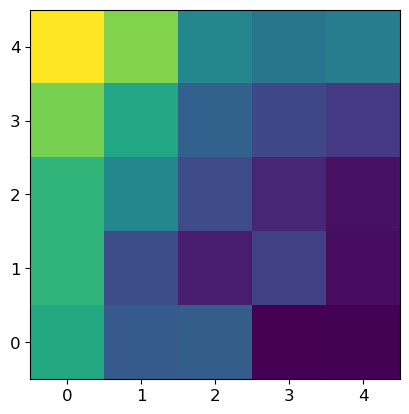

In [84]:
plt.imshow(statistic, origin='lower')

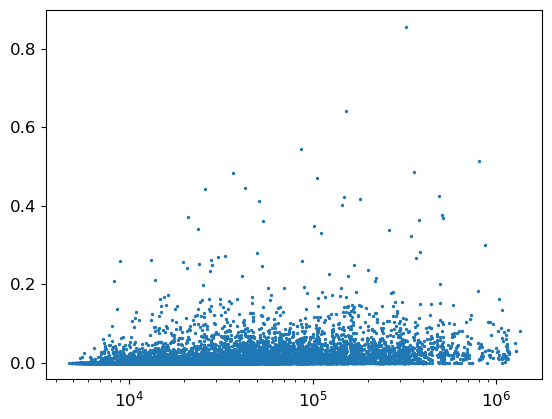

In [50]:



x = data_i['base_GaussianFlux_instFlux']
#y = 2*(data_i['ext_shapeHSM_HsmShapeRegauss_sigma'][mask]*pixscale)**2
y = data_i['slot_ModelFlux_initial_ellipse_xx'] + data_i['slot_ModelFlux_initial_ellipse_yy']

mask = (y > 0.) * (y < 1000.0)


plt.scatter(x[mask],y[mask]*pixscale**2,s=2)
plt.xscale('log')

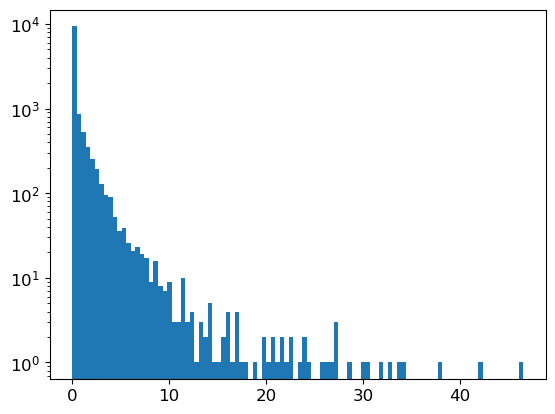

In [46]:
_=plt.hist( data_i['slot_ModelFlux_initial_ellipse_xx'], bins=100)
plt.yscale('log')

In [21]:
image.getWcs()

FITS standard SkyWcs:
Sky Origin: (270.1935592601, -24.9558830185)
Pixel Origin: (1912.74, 2298.51)
Pixel Scale: 0.0956783 arcsec/pixel

In [35]:
for c in  data.columns:
    print(datat

id
coord_ra
coord_dec
parent
base_SdssCentroid_x
slot_Centroid_x
base_SdssCentroid_y
slot_Centroid_y
base_SdssCentroid_flag
base_GaussianFlux_flag_badCentroid
base_PsfFlux_flag_badCentroid
ext_convolved_ConvolvedFlux_0_flag_badCentroid
ext_convolved_ConvolvedFlux_1_flag_badCentroid
ext_convolved_ConvolvedFlux_2_flag_badCentroid
ext_convolved_ConvolvedFlux_3_flag_badCentroid
ext_convolved_ConvolvedFlux_flag_badCentroid
ext_photometryKron_KronFlux_flag_badInitialCentroid
ext_shapeHSM_HsmPsfMoments_flag_badCentroid
ext_shapeHSM_HsmShapeRegauss_flag_badCentroid
ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid
ext_shapeHSM_HsmSourceMoments_flag_badCentroid
modelfit_DoubleShapeletPsfApprox_flag_badCentroid
slot_Centroid_flag
base_SdssCentroid_flag_edge
base_GaussianFlux_flag_badCentroid_edge
base_PsfFlux_flag_badCentroid_edge
ext_convolved_ConvolvedFlux_0_flag_badCentroid_edge
ext_convolved_ConvolvedFlux_1_flag_badCentroid_edge
ext_convolved_ConvolvedFlux_2_flag_badCentroid_edge
ext_convo

In [5]:
idx = 2
collections = ['LATISS/runs/AUXTEL_DRP_IMAGING_2023-03B/w_2023_08/PREOPS-3327/20230321T184436Z']
subbutler = Butler(repo,collections=collections)
subregistry = subbutler.registry
refs = list(subregistry.queryDatasets(datasetType='postISRCCD', collections=collections)) 
image = subbutler.get('postISRCCD',dataId = refs[idx].dataId, collections=collections)
isr_metadata = subbutler.get('isr_metadata',dataId = refs[idx].dataId, collections=collections)
isr_config = subbutler.get('isr_config',dataId = refs[idx].dataId, collections=collections)
#refs = list(subregistry.queryDatasets(datasetType='icSrc', collections=collections)) 
data = subbutler.get('icSrc', dataId = refs[idx].dataId, visit = refs[idx].dataId['exposure'], collections=collections)


IndexError: list index out of range

In [18]:
for scheme in data.schema:
    print(scheme.field.getName(), " : ", scheme.field.getDoc())


id  :  unique ID
coord_ra  :  position in ra/dec
coord_dec  :  position in ra/dec
parent  :  unique ID of parent source
calib_psf_candidate  :  Flag set if the source was a candidate for PSF determination, as determined by the star selector.
calib_psf_used  :  Flag set if the source was actually used for PSF determination, as determined by the
calib_psf_reserved  :  set if source was reserved from PSF determination
base_SdssCentroid_x  :  centroid from Sdss Centroid algorithm
base_SdssCentroid_y  :  centroid from Sdss Centroid algorithm
base_SdssCentroid_xErr  :  1-sigma uncertainty on x position
base_SdssCentroid_yErr  :  1-sigma uncertainty on y position
base_SdssCentroid_flag  :  General Failure Flag
base_SdssCentroid_flag_edge  :  Object too close to edge; peak used.
base_SdssCentroid_flag_noSecondDerivative  :  Vanishing second derivative
base_SdssCentroid_flag_almostNoSecondDerivative  :  Almost vanishing second derivative
base_SdssCentroid_flag_notAtMaximum  :  Object is not at 

Sort through the data and combine all data into one.

In [20]:
def trim(data, mask=None):
    
    if mask is None:
        mask = (data['calib_psf_candidate']==True)

    
    return data[mask]

def extract(collections):
    
    butler = Butler(repo,collections=collections)
    registry = subbutler.registry
    refs = np.sort(list(registry.queryDatasets(datasetType='postISRCCD', \
                                               collections=collections)))

    data_list = []
    data_ids = []
    num_failed = 0
    for i, ref in enumerate(refs):
        loader(i,len(refs))
        try:
            datum = butler.get('icSrc', dataId = ref.dataId, \
                                        visit=ref.dataId['exposure'], \
                                        collections=collections).asAstropy()
            data_list.append(datum)
            data_ids.extend([ref.dataId]*len(datum))
            del datum
        except:
            num_failed += 1
            
    data = vstack(data_list)

    data['dataId']=data_ids
    
    del data_list
    
    if num_failed != 0:
        print()
        print(f"~~~~ WARNING: {num_failed} out of {len(refs)} references failed. ~~~~")
    
    return data

In [21]:
collections = ['u/abrought/latiss/stars.SDSSg_65mm.2023.08.03',
               'u/abrought/latiss/stars.SDSSg_65mm.2023.08.17',
               'u/abrought/latiss/stars.SDSSg_65mm.2023.08.29']

data_g = trim(extract(collections))

[....................................................................................................] 298/298 (100.0%)
~~~~ WARNING: 6 out of 298 references failed. ~~~~


In [22]:
collections = ['u/abrought/latiss/stars.SDSSr_65mm.2023.08.03',
               'u/abrought/latiss/stars.SDSSr_65mm.2023.08.17',
               'u/abrought/latiss/stars.SDSSr_65mm.2023.08.29']

data_r = trim(extract(collections))

In [23]:
collections = ['u/abrought/latiss/stars.SDSSi_65mm.2023.08.03',
               'u/abrought/latiss/stars.SDSSi_65mm.2023.08.17',
               'u/abrought/latiss/stars.SDSSi_65mm.2023.08.29']

data_i = trim(extract(collections))

[....................................................................................................] 281/281 (100.0%)
~~~~ WARNING: 2 out of 281 references failed. ~~~~


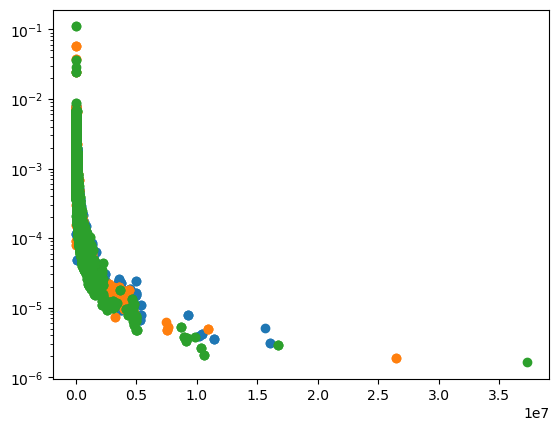

In [50]:
plt.scatter(data_g['base_GaussianFlux_instFlux'],data_g['slot_Shape_xx']/data_g['base_PsfFlux_instFlux'])
plt.scatter(data_r['base_GaussianFlux_instFlux'],data_r['slot_Shape_xx']/data_r['base_PsfFlux_instFlux'])
plt.scatter(data_i['base_GaussianFlux_instFlux'],data_i['slot_Shape_xx']/data_i['base_PsfFlux_instFlux'])
plt.yscale('log')

Orthogonal Distance Regression

In [54]:
def linear(x, a0, a1):
    return a0 * x + a1

from scipy.optimize import curve_fit

x = data_g['base_GaussianFlux_instFlux']
y = data_g['slot_Shape_xx']
xerr = data_g['base_GaussianFlux_instFluxErr']


popt, pcov = curve_fit(linear, x, y, sigma=1/xerr)
a0, a1 = popt
a0_err, a1_err = np.diag(np.sqrt(pcov))
a0_new = (1./a0)
a0_new_err = a0_new*(a0_err/a0)
a1_new = -a1/a0
a1_new_err = np.abs(a1_new * np.sqrt((a1_err/a1)**2 + (a0_err/a0)**2))

print("a0:", a0, "+/-",  a0_err)
print("a1:", a1, "+/-",  a1_err)

a0: -6.155896534068322e-07 +/- 4.6003720206509316e-08
a1: 58.63844805411191 +/- 0.16130188910379706


/lscratch/abrought/ipykernel_1812967/2857627736.py:13: RuntimeWarning: invalid value encountered in sqrt
  a0_err, a1_err = np.diag(np.sqrt(pcov))


In [55]:
x = np.linspace(0,1e7)
y = a0*x + a1

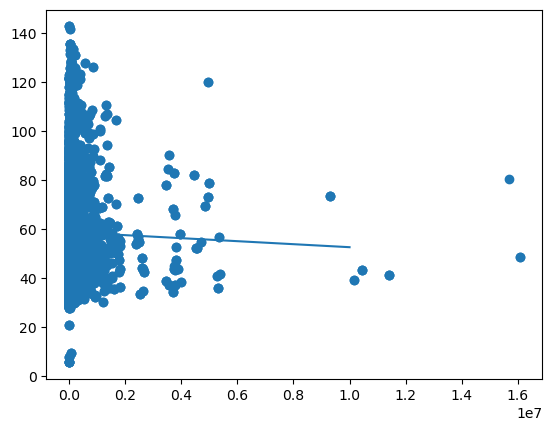

In [56]:
plt.scatter(data_g['base_GaussianFlux_instFlux'],data_g['slot_Shape_xx'])
plt.plot(x,y)


array([  503.70930593, 12062.36146571])

In [25]:
print(len(data_g), len(data_r), len(data_i))

16960 32914 41870


In [37]:
wcs = get_astropy_wcs(image)
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 240.02594033158988  -23.955872779376634  
CRPIX : 2089.0  2007.0  
CD1_1 CD1_2  : 2.65819441652572e-05  -3.8526189976698e-09  
CD2_1 CD2_2  : 3.85261899732325e-09  2.65819441652575e-05  
NAXIS : 0  0


In [38]:
def fill_catalog(refs):
    """ 
    Will loop through all butlerized dataset refs (each corresponding
    to one exposure) and calculate the photometry for each star in all 
    exposures.

    Usage:
    for i in range(len(arr)):
        loader(i,len(arr))

    Parameters
    ----------
    refs: array-like of lsst.daf.butler.core.datasets.ref.DatasetRef objects
        Current index

    Returns
    -------
    output: numpy.ndarray
        Concatenated 2D array where each row is a star from a single exposure
        and the columns are [max signal, Ixx, Iyy, Ixy, sigma, total signal]

    """

    output = np.array([np.nan, np.nan, np.nan,np.nan,np.nan,np.nan])
    for n,r in enumerate(refs):
        print(f"{n+1}/{len(refs)}")
        image = subbutler.get('postISRCCD',dataId = r.dataId, collections=['u/abrought/latiss/stars.2023.08.03'])
        catalog = subbutler.get('spotSrc',dataId = r.dataId, collections=['u/abrought/latiss/stars.2023.08.03'])
        
        mask = (catalog['base_SdssCentroid_flag_near_edge']==False) * (catalog['base_CircularApertureFlux_flag_badCentroid']==False) * (catalog['base_SdssShape_instFlux'] > 2e5)
        
        for i,star in enumerate(catalog[mask]):
            _,result = get_star_stats(catalog[mask],image, i, showSpot=False)
            output = np.vstack((output,result))
        del image
        del catalog
        
    return output

In [15]:
output = fill_catalog(refs)

1/133
2/133
3/133
4/133
5/133
6/133
7/133
8/133
9/133
10/133
11/133
12/133
13/133
14/133
15/133
16/133
17/133
18/133
19/133
20/133
21/133
22/133
23/133
24/133
25/133
26/133
27/133
28/133
29/133
30/133
31/133
32/133
33/133
34/133
35/133
36/133
37/133
38/133
39/133
40/133
41/133
42/133
43/133
44/133
45/133
46/133
47/133
48/133
49/133
50/133
51/133
52/133
53/133
54/133
55/133
56/133
57/133
58/133
59/133
60/133
61/133
62/133
63/133
64/133
65/133
66/133
67/133
68/133
69/133
70/133
71/133
72/133
73/133
74/133
75/133
76/133
77/133
78/133
79/133
80/133
81/133
82/133
83/133
84/133
85/133
86/133
87/133
88/133
89/133
90/133
91/133
92/133
93/133
94/133
95/133
96/133
97/133
98/133
99/133
100/133
101/133
102/133
103/133
104/133
105/133
106/133
107/133
108/133
109/133
110/133
111/133
112/133
113/133
114/133
115/133
116/133
117/133
118/133
119/133
120/133
121/133
122/133
123/133
124/133
125/133
126/133
127/133
128/133
129/133
130/133
131/133
132/133
133/133


In [ ]:
np.save("./output_g.npy",output)

##### Load in all of our data

In [39]:
output_g = np.load("./output_g.npy")
output_r = np.load("./output_r.npy")
output_i = np.load("./output_i.npy")

##### Let's visualize all of our data

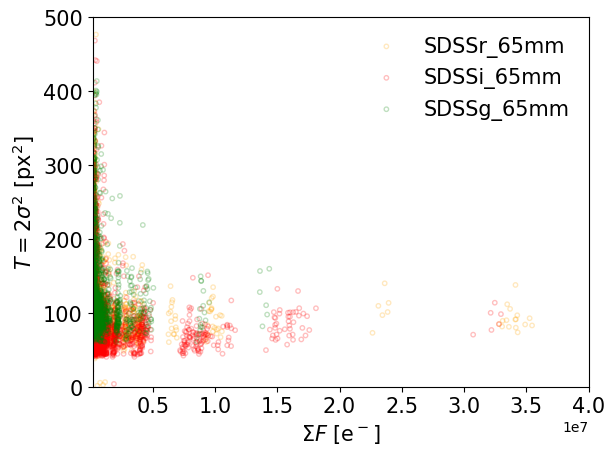

In [40]:
plt.scatter(output_r[:,5], 2*output_r[:,4]**2, marker="o", s=10, facecolor="None", edgecolor="orange", alpha=0.25, label='SDSSr_65mm')
plt.scatter(output_i[:,5], 2*output_i[:,4]**2, marker="o", s=10, facecolor="None", edgecolor="red", alpha=0.25, label='SDSSi_65mm')
plt.scatter(output_g[:,5], 2*output_g[:,4]**2, marker="o", s=10, facecolor="None", edgecolor="g", alpha=0.25, label='SDSSg_65mm')
plt.xlim(1.75e5,0.4e8)
plt.ylim(0,500)
#plt.xscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$\Sigma F$ [$\mathrm{e}^-$]', fontsize=15)
plt.ylabel(r'$T = 2\sigma^2$ [$\mathrm{px}^2$]', fontsize=15)
plt.legend(frameon=False, fontsize=15)

##### Let's examine the type of data from that night

In [41]:
subbutler = Butler(repo,collections=['u/abrought/latiss/stars.2023.08.03'])
subregistry = subbutler.registry
refs = list(subregistry.queryDatasets(datasetType='postISRCCD', collections=['u/abrought/latiss/stars.2023.08.03'])) 
raw = subbutler.get('raw',dataId = refs[2].dataId, collections=['u/abrought/latiss/stars.2023.08.03'])
#catalog = subbutler.get('spotSrc',dataId = refs[2].dataId, collections=['u/abrought/latiss/stars.2023.08.03'])

In [42]:
import matplotlib.patches as patches

In [43]:
pointings_ra = []
pointings_dec = []
pointings_theta = []
for i, ref in enumerate(refs):
    loader(i,len(refs))
    raw = subbutler.get('raw',dataId = refs[i].dataId, collections=['u/abrought/latiss/stars.2023.08.03'])
    ra = raw.getMetadata()['RA']
    dec = raw.getMetadata()['DEC']
    theta = raw.getMetadata()['ROTPA']
    pointings_ra.append(ra)
    pointings_dec.append(dec)
    pointings_theta.append(theta)
    del raw

auxtel_pix_size = 0.095695 # arcsec / pixel
arcsec_to_degrees = 0.000277778 # deg / arcsec
width, height = auxtel_pix_size* arcsec_to_degrees *4000, auxtel_pix_size * arcsec_to_degrees * 4000

exp_patches = []
for (ra,dec,theta) in zip(pointings_ra,pointings_dec, pointings_theta):
    patch = patches.Rectangle((ra-width/2., dec-height/2.), width, height, angle=theta, rotation_point='center', linewidth=1, alpha=0.5,edgecolor='g', facecolor='none')
    exp_patches.append(patch)

Plot a rough (un-projected) outline of the the image regions. This is OK for rough visualization because the <br>
fixed-planes in each exposure are mostly aligned anyways.

239.62581906598 270.57759068964504 -25.36362565065611 -23.636908473977222


RuntimeError: Can not put single artist in more than one figure

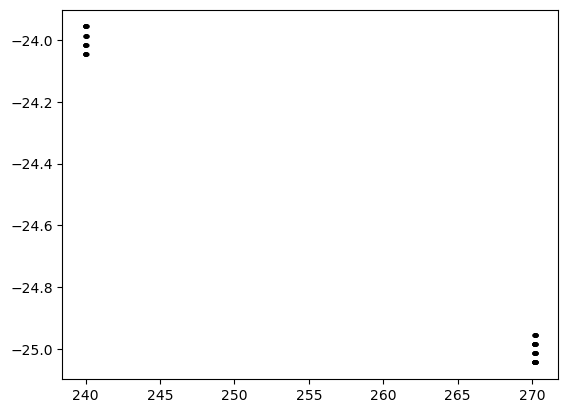

In [50]:
s = 3
minx = np.min(pointings_ra)-s*width
maxx = np.max(pointings_ra)+s*width
miny = np.min(pointings_dec)-s*height
maxy = np.max(pointings_dec)+s*height

print(minx, maxx, miny, maxy)

fig, ax = plt.subplots()
ax.plot(pointings_ra, pointings_dec, "o", markersize=2, color="k")
for patch in exp_patches:
    ax.add_patch(patch)

plt.xlim(240-.1,240+.1)
plt.ylim(-24-0.1,-24+0.1)

# Improved Object Detection
Here, we will ignore the output from the CharacterizeSpotTask and use other ways to identify stars from the post-ISR
images themselves.

In [51]:
subbutler = Butler(repo,collections=['u/abrought/latiss/stars.2023.08.03'])
subregistry = subbutler.registry
refs = list(subregistry.queryDatasets(datasetType='postISRCCD', collections=['u/abrought/latiss/stars.2023.08.03'])) 
image = subbutler.get('postISRCCD',dataId = refs[10].dataId, collections=['u/abrought/latiss/stars.2023.08.03'])

In [54]:
def interpolate_background(array, method='nearest'):
    """ 
    Interpolation of np.nan values in a 2D array.
    """
    array[array==0] = np.nan
    x = np.arange(0, array.shape[1])
    y = np.arange(0, array.shape[0])
    #mask invalid values
    array = np.ma.masked_invalid(array)
    xx, yy = np.meshgrid(x, y)
    #get only the valid values
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]

    interpolated_array = interpolate.griddata((x1, y1), newarr.ravel(), (xx, yy), method=method)

    return interpolated_array

def remove_background(image):
    """ 
    Model and remove the background from an image (numpy.ndarray), 
    clipping out the 5 sigma sources.
    """

    from astropy.stats import SigmaClip
    from photutils.background import Background2D,MedianBackground, SExtractorBackground

    # First pass to get rough background estimate
    sigmaclip = SigmaClip(sigma=5.)
    bkg_estimator = MedianBackground()
    bkg = Background2D(image, (65,65), filter_size=(5, 5), 
                        sigma_clip=sigmaclip, 
                        bkg_estimator=bkg_estimator)


    # Second pass ignoring spots pixels
    diff = image - bkg.background
    from astropy.stats import sigma_clip
    coverage_mask = sigma_clip(diff, sigma=5, grow=2.0,maxiters=5, masked=True).mask
    del diff
    bkg = Background2D(image, (65, 65), filter_size=(5, 5), 
                        sigma_clip=None, 
                        bkg_estimator=bkg_estimator, 
                        coverage_mask=coverage_mask)

    # Interpolate over spot regions (coverage mask area)
    new_bkg = interpolate_background(bkg.background)

    return image - new_bkg



In [55]:
img = remove_background(image.getImage().getArray())

Despite doing per-row overscan subtraction, there is still residual banding visible in the image. But we will just have to deal with this for now.

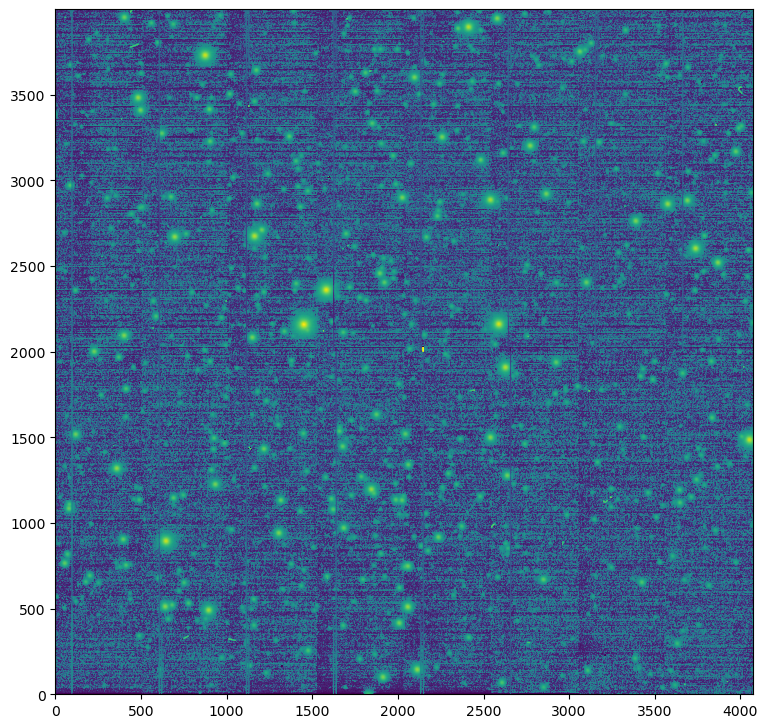

In [56]:
import matplotlib
plt.figure(figsize=(9,9))
plt.imshow(img, origin='lower', norm=matplotlib.colors.SymLogNorm(10**-0, vmin=-10, vmax=15000))

##### We will implement the DAOStarFinder algorithm, which is implemented in the $\texttt{photutils}$ module.

In [57]:
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder

mean, median, std = sigma_clipped_stats(img, sigma=3.0)
daofind = DAOStarFinder(fwhm=10.0, threshold=5.*std)  
stars = daofind(img)  
for col in stars.colnames:  
    if col not in ('id', 'npix'):
        stars[col].info.format = '%.2f'  # for consistent table output
stars.pprint(max_width=76)  
print(f"Found {len(stars)} stars!")

 id xcentroid ycentroid sharpness roundness1 ... sky    peak   flux  mag 
--- --------- --------- --------- ---------- ... ---- ------- ----- -----
  1    495.50      7.45      0.96      -0.10 ... 0.00   13.76  1.10 -0.11
  2   2909.69      7.10      0.91      -0.59 ... 0.00   15.95  1.08 -0.08
  3   2850.37     39.52      0.66      -0.14 ... 0.00   62.27  1.70 -0.58
  4   2607.41     66.57      0.46      -0.02 ... 0.00  144.97  4.22 -1.56
  5   1913.01     98.49      0.48      -0.16 ... 0.00  532.45 14.32 -2.89
  6   2112.99    142.60      0.40      -0.10 ... 0.00  898.85 25.37 -3.51
  7   3403.84    148.54      0.24      -0.69 ... 0.00   14.94  1.93 -0.71
...       ...       ...       ...        ... ...  ...     ...   ...   ...
189   2411.85   3889.15      0.33      -0.00 ... 0.00 2267.06 72.76 -4.65
190    689.68   3905.60      0.28      -0.10 ... 0.00   64.12  2.43 -0.97
191    562.09   3912.60      0.21       0.05 ... 0.00   54.68  2.01 -0.76
192   2093.01   3940.84      0.61     

##### Now let's visualize all the sources that we've found.

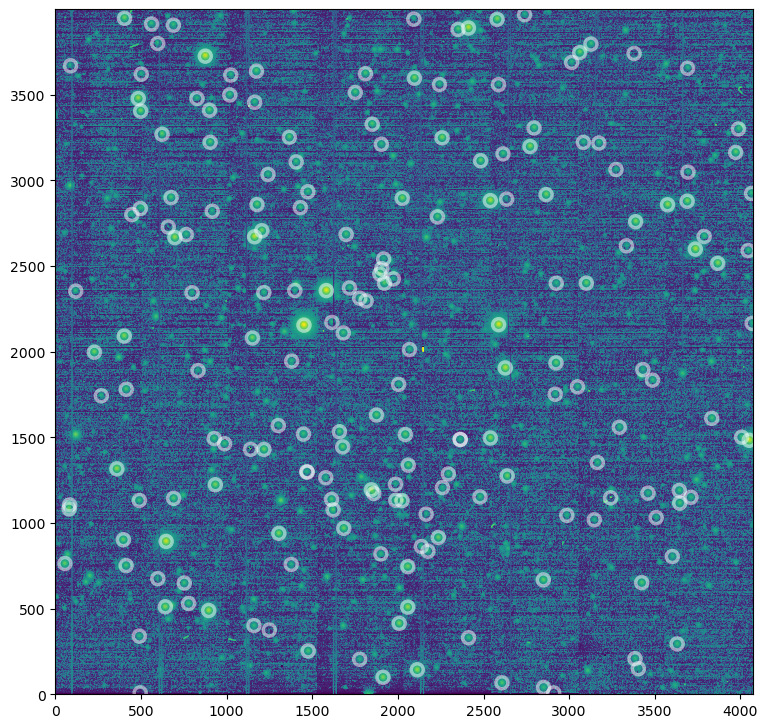

In [58]:
from astropy.visualization import SqrtStretch
#from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

positions = np.transpose((stars['xcentroid'], stars['ycentroid']))

apertures = CircularAperture(positions, r=35)
#norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(9,9))
plt.imshow(img, origin='lower', norm=matplotlib.colors.SymLogNorm(10**-0, vmin=-10, vmax=15000))
_ = apertures.plot(color='white', lw=2.5, alpha=0.5)

In [59]:
def remove_blended_sources(src, thresh):
    """
    Remove sources that are within some threshold distance from another source in the same image.

    
    """
    import itertools

    new_src = src.copy()
    combinations = list(itertools.combinations(range(0,len(src)-1), 2))
    #print(len(src), np.min(range(0,len(src))), np.max(range(0,len(src))))
    bad = []
    for pair in combinations:
        (i,j) = src[pair[0]], src[pair[1]]
        good = (np.sqrt((i['xcentroid'] - j['xcentroid'])**2 + (i['ycentroid'] - j['ycentroid'])**2) > thresh)
        
        if not good:
            bad.extend(pair)

    if len(bad) == 0:
        return src
        
    new_src.remove_rows(np.unique(bad))
    #print(f"{len(src)} -> {len(new_src)}")

    return new_src

In [60]:
stars_reduced = remove_blended_sources(stars, 100.)
stars_reduced.pprint(max_width=76)  

 id xcentroid ycentroid sharpness roundness1 ... sky   peak   flux  mag 
--- --------- --------- --------- ---------- ... ---- ------ ----- -----
  1    495.50      7.45      0.96      -0.10 ... 0.00  13.76  1.10 -0.11
  4   2607.41     66.57      0.46      -0.02 ... 0.00 144.97  4.22 -1.56
  5   1913.01     98.49      0.48      -0.16 ... 0.00 532.45 14.32 -2.89
  6   2112.99    142.60      0.40      -0.10 ... 0.00 898.85 25.37 -3.51
  8   1776.84    203.79      0.62      -0.05 ... 0.00  41.25  1.18 -0.18
 10   1476.19    252.45      0.27      -0.00 ... 0.00  98.95  3.07 -1.22
 11   3630.19    293.32      0.40      -0.01 ... 0.00  58.82  1.75 -0.60
...       ...       ...       ...        ... ...  ...    ...   ...   ...
187    598.25   3798.72      0.47       0.24 ... 0.00  60.19  2.80 -1.12
190    689.68   3905.60      0.28      -0.10 ... 0.00  64.12  2.43 -0.97
191    562.09   3912.60      0.21       0.05 ... 0.00  54.68  2.01 -0.76
192   2093.01   3940.84      0.61      -0.20 ... 0.

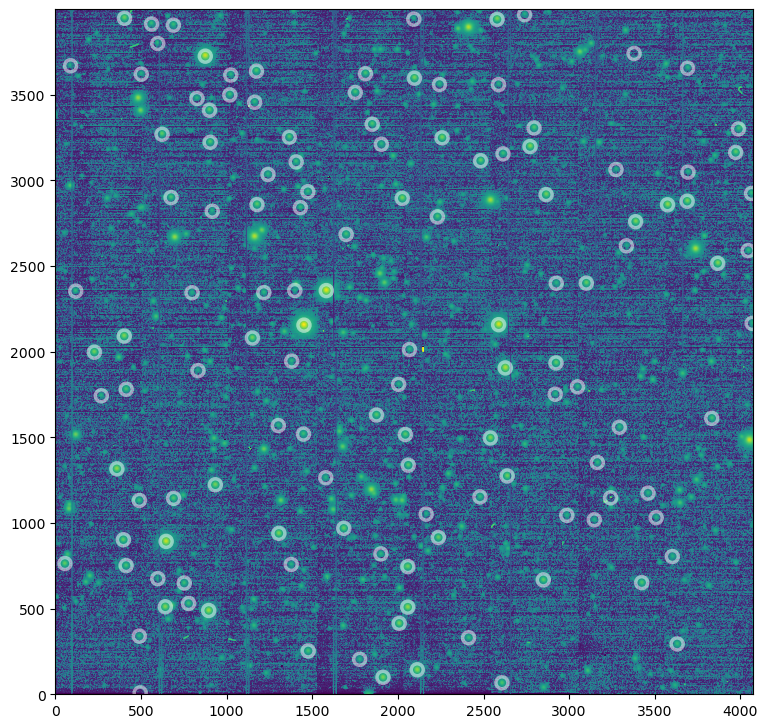

In [61]:
from astropy.visualization import SqrtStretch
#from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

positions = np.transpose((stars_reduced['xcentroid'], stars_reduced['ycentroid']))

apertures = CircularAperture(positions, r=35)
#norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(9,9))
plt.imshow(img, origin='lower', norm=matplotlib.colors.SymLogNorm(10**-0, vmin=-10, vmax=15000))
_ = apertures.plot(color='white', lw=2.5, alpha=0.5)

In [62]:
def remove_edge_sources_from_catalog(catalog,npix=30):
    from lsst.obs.lsst import Latiss
    camera = Latiss().getCamera()

    new_catalog = catalog.copy()
    good_sources = np.zeros((len(new_catalog),16), dtype=bool)

    for i, amp in enumerate(camera[0].getAmplifiers()):
        xmin = amp.getBBox().erodedBy(npix).minX
        xmax = amp.getBBox().erodedBy(npix).maxX
        ymin = amp.getBBox().erodedBy(npix).minY
        ymax = amp.getBBox().erodedBy(npix).maxY

        good = (catalog['ycentroid'] > ymin) \
            * (catalog['ycentroid'] < ymax+1) \
            * (catalog['xcentroid'] > xmin) \
            * (catalog['xcentroid'] < xmax+1)

        
        good_sources[:,i] = good
    

    mask = np.any(good_sources,axis=1)

    return new_catalog[mask]


In [63]:
def get_excluded_edges(npix=30):
    """
    Returns a numpy.ndarray where True if near an amplifier or detector edge.
    

    """
    from lsst.obs.lsst import Latiss
    camera = Latiss().getCamera()

    included = np.zeros((camera[0].getBBox().height, camera[0].getBBox().width), dtype=bool)

    for i, amp in enumerate(camera[0].getAmplifiers()):

        xmin = amp.getBBox().erodedBy(npix).minX
        xmax = amp.getBBox().erodedBy(npix).maxX
        ymin = amp.getBBox().erodedBy(npix).minY
        ymax = amp.getBBox().erodedBy(npix).maxY

        included[ymin:ymax+1,xmin:xmax+1] = True

    return ~included


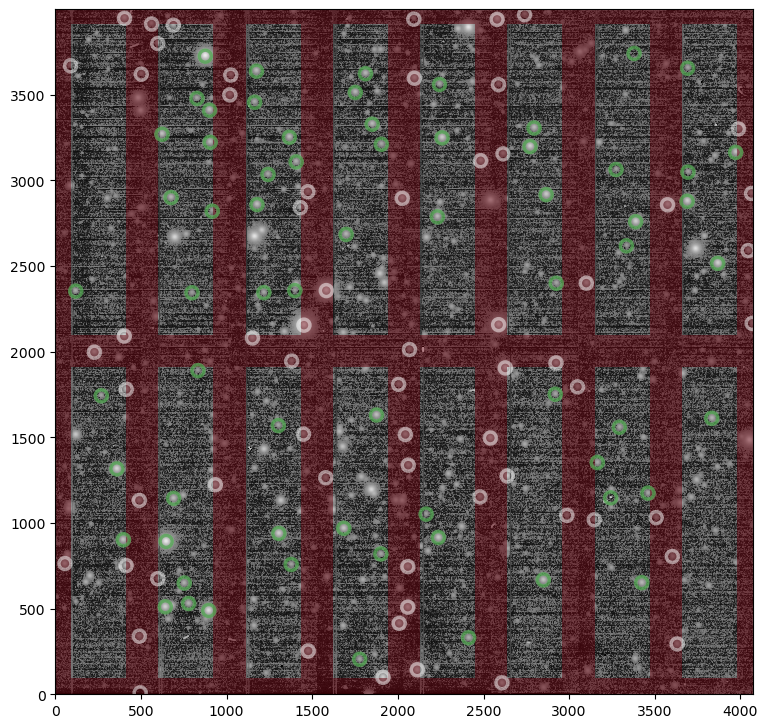

In [64]:
from astropy.visualization import SqrtStretch
from photutils.aperture import CircularAperture

# Number of pixels to clip off of edge
npix = 100

plt.figure(figsize=(9,9))

# Plot the image
plt.imshow(img, origin='lower', cmap="binary_r",norm=matplotlib.colors.SymLogNorm(10**-0, vmin=-10, vmax=15000))

# Plot the edges region in red
mask = get_excluded_edges(npix=npix)
arr = np.ones(mask.shape)
arr[~mask] = np.nan
plt.imshow(arr, origin='lower', vmin=0, vmax=1,cmap="Reds", alpha=0.5)

# Get the positions of all the stars, and plot them in white
positions = np.transpose((stars_reduced['xcentroid'], stars_reduced['ycentroid']))
apertures = CircularAperture(positions, r=35)
_ = apertures.plot(color='white', lw=2.5, alpha=0.5)

# Get the positions of all the stars and plot them in green
stars_final = remove_edge_sources_from_catalog(stars_reduced, npix=npix)
positions = np.transpose((stars_final['xcentroid'], stars_final['ycentroid']))
apertures = CircularAperture(positions, r=35)
_ = apertures.plot(color='green', lw=2.5, alpha=0.5)

In [67]:
result = np.full( (len(stars_final), 6), np.nan )
for i in range(len(stars_final)):
    _, stats = get_star_stats(stars_final, image.getImage().getArray(), i, showSpot=False)
    result[i,:] = stats


Get a rough idea of the feature matrix:

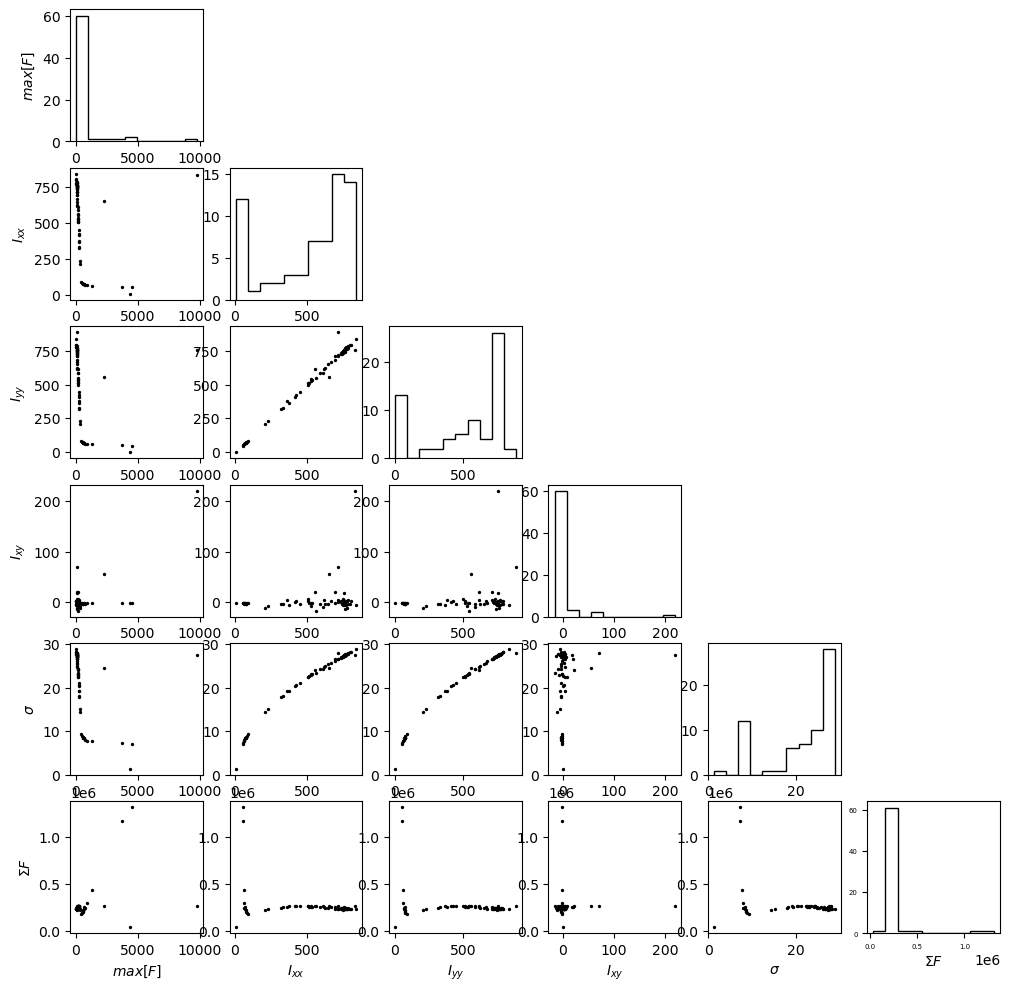

In [86]:
n = 6
import itertools

fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(12,12))

labels = ["$max[F]$","$I_{xx}$","$I_{yy}$","$I_{xy}$","$\sigma$","$\Sigma F$"]

for i in range(n):
    for j in range(n):

        ax = axs[i][j]

        if i < j:
            ax.set_visible(False)

        if i == j:
            _ = ax.hist(result[:,i], color='k',histtype='step')
        else:
            _ = ax.scatter(result[:,j],result[:,i], marker="o", color="k", s=2)
        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
        if i == 5: 
            ax.set_xlabel(labels[j])
        if j == 0:
            ax.set_ylabel(labels[i])
        #ax.set_title(f"({i}, {j})")


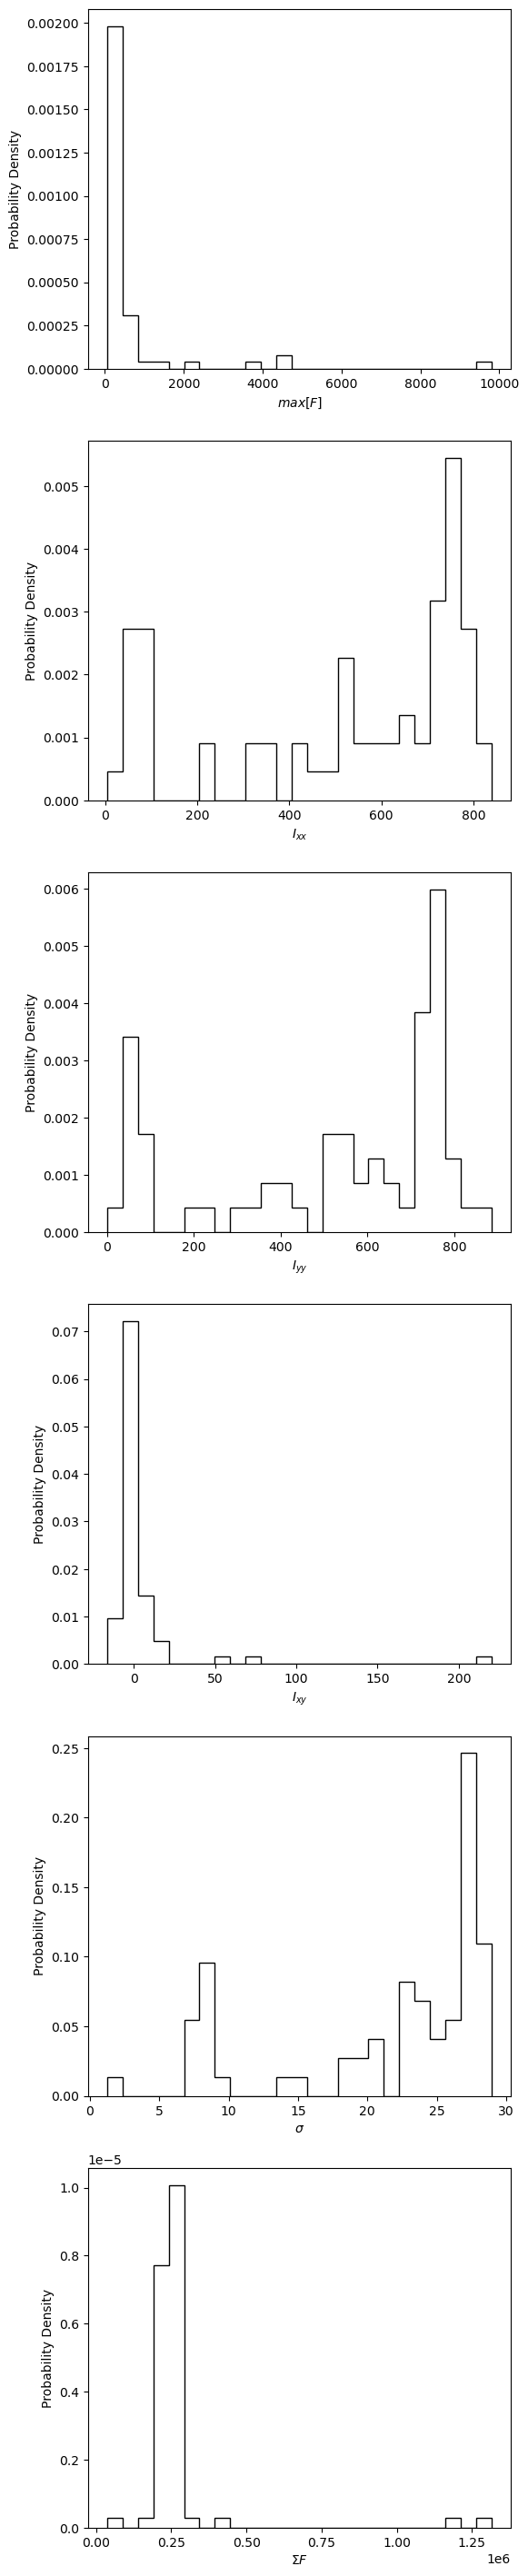

In [87]:
fig, axs = plt.subplots(n,1,figsize=(6,6*n))
matplotlib.rcParams.update({'font.size': 15})
for i in range(n):
    ax = axs[i]
    _ = ax.hist(result[:,i], bins=25,color='k',histtype='step', density=True)
    ax.set_xlabel(labels[i])
    ax.set_ylabel("Probability Density")

Text(0, 0.5, 'Ixx')

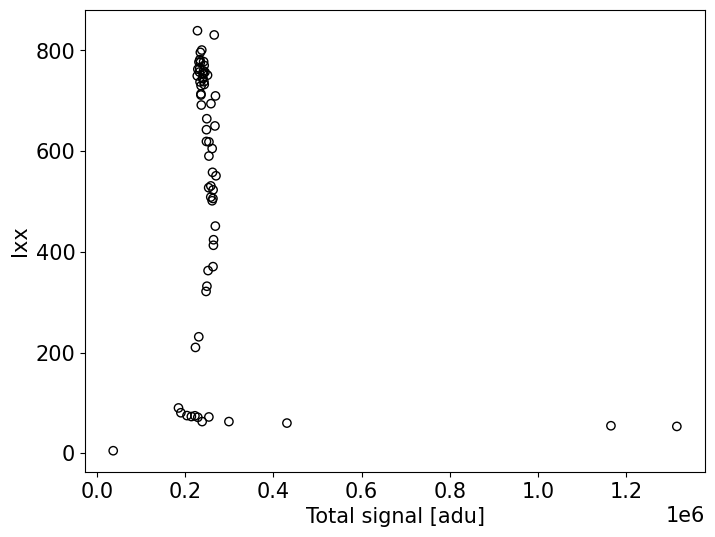

In [89]:
plt.figure(figsize=(8,6))
_  = plt.scatter(result[:,5],result[:,1], marker="o", edgecolor="k", facecolor="None")
plt.xlabel("Total signal [adu]")
plt.ylabel("Ixx")

##### Now do this for all the sources

These functions will run all the above steps for each exposure in the dataset refs array:

In [90]:
def get_stars(refs):
    output = np.array([np.nan, np.nan, np.nan,np.nan,np.nan,np.nan])
    nstars = np.zeros(len(refs))
    for n,r in enumerate(refs):
        # Print progress
        loader(n, len(refs), scaled=False)

        # Get the image
        image = subbutler.get('postISRCCD',dataId = r.dataId, collections=['u/abrought/latiss/stars.SDSSr_65mm.2023.08.03'])

        # Remove the background
        img = remove_background(image.getImage().getArray())

        # Find the stars
        mean, median, std = sigma_clipped_stats(img, sigma=3.0)
        daofind = DAOStarFinder(fwhm=10.0, threshold=5.*std)  
        stars = daofind(img)
        
        # Find the best sources
        npix = 100
        stars = remove_blended_sources(stars, 100.)
        stars = remove_edge_sources_from_catalog(stars, npix=npix)

        # Get the statistics for each star
        res = np.full( (len(stars), 6), np.nan )
        for i in range(len(stars)):
            _, stats = get_star_stats(stars, img, i, showSpot=False)
            res[i,:] = stats
        
        output = np.vstack((output,res))
        nstar[n] = len(stars)
        
    return output

In [91]:
def get_stars_single_exposure(r):
    # Get the image
    image = subbutler.get('postISRCCD',dataId = r.dataId, collections=['u/abrought/latiss/stars.SDSSr_65mm.2023.08.03'])

    # Remove the background
    img = remove_background(image.getImage().getArray())

    # Find the stars
    mean, median, std = sigma_clipped_stats(img, sigma=3.0)
    daofind = DAOStarFinder(fwhm=10.0, threshold=5.*std)  
    stars = daofind(img)

    if len(stars) == 0:
        return np.array([np.nan, np.nan, np.nan,np.nan,np.nan,np.nan])
    
    # Find the best sources
    npix = 100
    stars = remove_blended_sources(stars, 100.)

    if len(stars) == 0:
        return np.array([np.nan, np.nan, np.nan,np.nan,np.nan,np.nan])

    stars = remove_edge_sources_from_catalog(stars, npix=npix)

    if len(stars) == 0:
        return np.array([np.nan, np.nan, np.nan,np.nan,np.nan,np.nan])

    # Get the statistics for each star
    res = np.full( (len(stars), 6), np.nan )
    for i in range(len(stars)):
        _, stats = get_star_stats(stars, img, i, showSpot=False)
        res[i,:] = stats
        
    return res

In [92]:
subbutler = Butler(repo,collections=['u/abrought/latiss/stars.SDSSr_65mm.2023.08.03'])
subregistry = subbutler.registry

refs = list(subregistry.queryDatasets(datasetType='postISRCCD', collections=['u/abrought/latiss/stars.SDSSr_65mm.2023.08.03'])) 


In [47]:
# Work in progress to implement multi-threading
def driver():
    PROCESSES = 2
    subbutler = Butler(repo,collections=['u/abrought/latiss/stars.SDSSr_65mm.2023.08.03'])
    subregistry = subbutler.registry

    refs = list(subregistry.queryDatasets(datasetType='postISRCCD', collections=['u/abrought/latiss/stars.SDSSr_65mm.2023.08.03'])) 

    with multiprocessing.Pool(PROCESSES) as pool:
        params = refs[0:2]
        results = [pool.apply_async(get_stars_single_exposure, p) for p in params]

        for r in results:
            print('\t', r.get())

driver_func()


[array([[ 3.79892206e+02,  1.38303980e+02,  1.21778731e+02,
         8.90269171e-01,  1.13919067e+01,  2.63001438e+05],
       [ 9.42275411e+01,  1.29389519e+02,  1.15260627e+02,
        -2.30519861e+00,  1.10498486e+01,  5.53563945e+04],
       [ 9.11062699e+02,  1.30966481e+00,  2.89114007e+00,
         1.71209815e+00,  9.61634099e-01,  5.96123340e+03],
       [ 3.06156369e+02,  1.51891500e+02,  1.37140841e+02,
        -8.66384586e+00,  1.20028152e+01,  2.19760047e+05],
       [ 7.27324942e+01,  1.33787084e+02,  1.23771261e+02,
         4.27278576e-01,  1.13437672e+01,  3.86443203e+04],
       [            nan,             nan,             nan,
                    nan,             nan,             nan],
       [ 4.06757382e+02,  1.31710792e+02,  1.21528267e+02,
         2.89415946e-01,  1.12479687e+01,  2.61362562e+05],
       [ 1.52022570e+02,  1.42739847e+02,  1.28381917e+02,
        -9.56725047e+00,  1.16203337e+01,  1.00313297e+05],
       [            nan,             nan,      

In [5]:
data_r = np.load("./improved_output_r.npy")
data_g = np.load("./improved_output_g.npy")
data_i = np.load("./improved_output_i.npy")

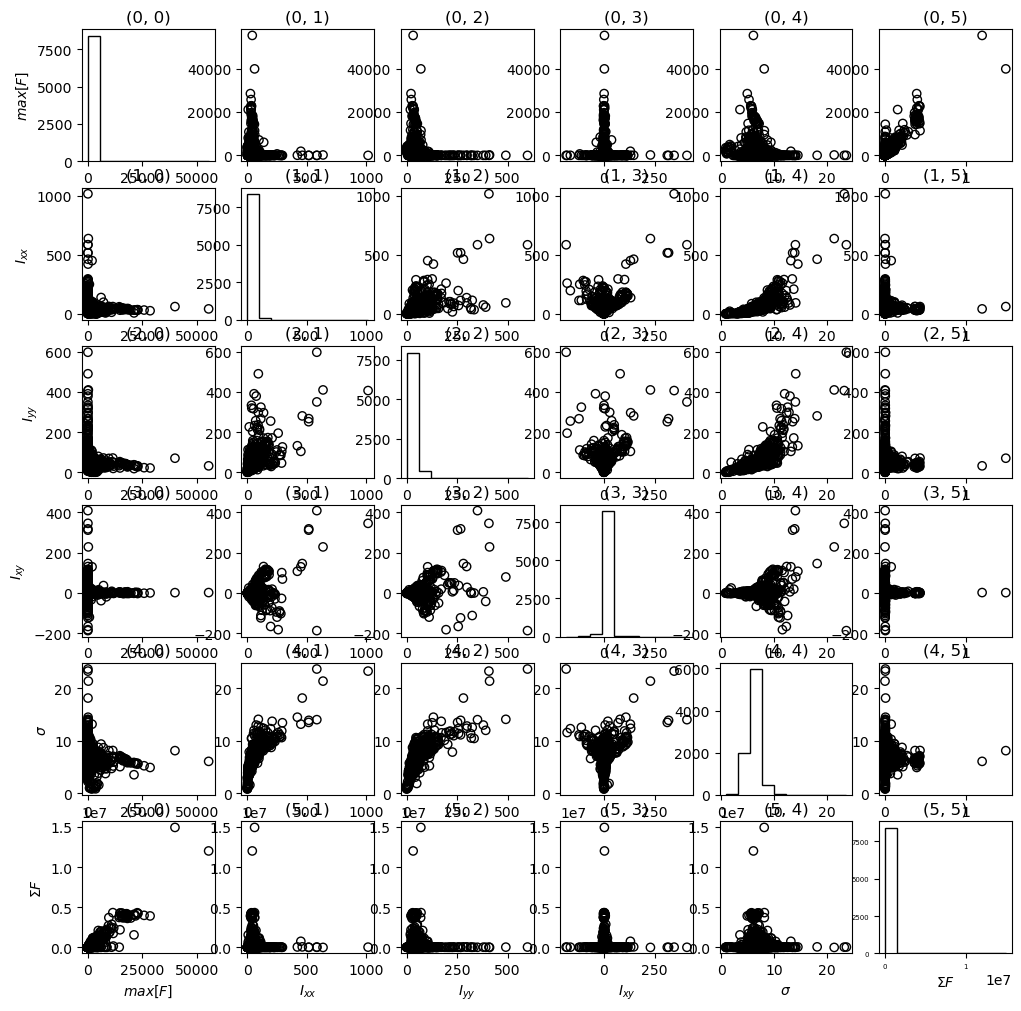

In [7]:
n = 6
import itertools

fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(12,12))

labels = ["$max[F]$","$I_{xx}$","$I_{yy}$","$I_{xy}$","$\sigma$","$\Sigma F$"]

for i in range(n):
    for j in range(n):
        ax = axs[i][j]
        if i == j:
            _ = ax.hist(data[:,i], color='k',histtype='step')
        else:
            _ = ax.scatter(data[:,j],data[:,i], marker="o", edgecolor="k", facecolor="None")
        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
        if i == 5: 
            ax.set_xlabel(labels[j])
        if j == 0:
            ax.set_ylabel(labels[i])
        ax.set_title(f"({i}, {j})")

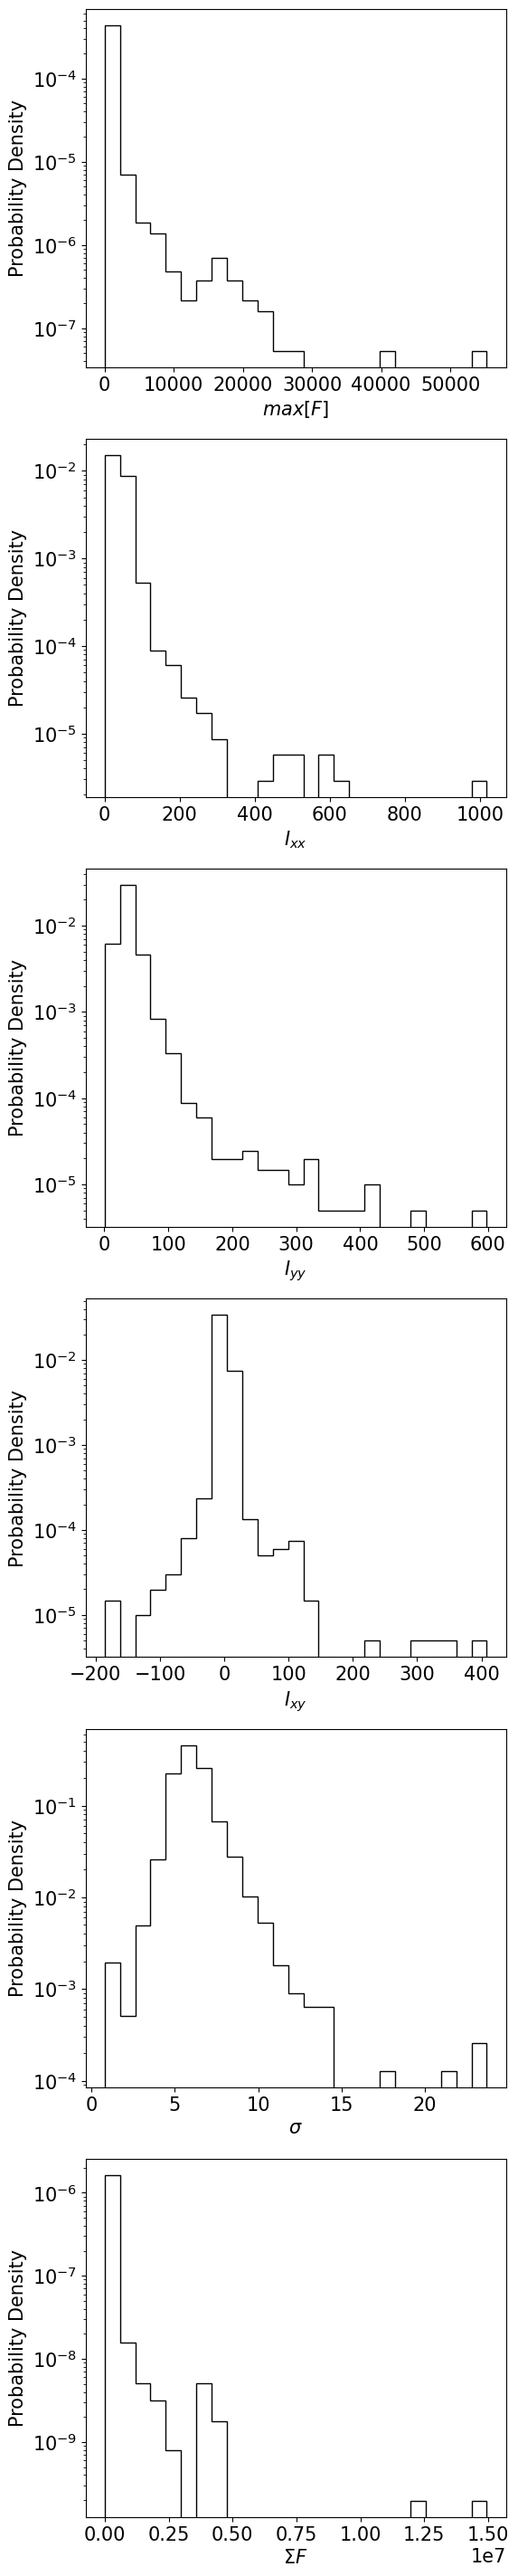

In [14]:
fig, axs = plt.subplots(n,1,figsize=(6,6*n))
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
for i in range(n):
    ax = axs[i]
    _ = ax.hist(data[:,i], bins=25,color='k',histtype='step', density=True)
    ax.set_xlabel(labels[i])
    ax.set_ylabel("Probability Density")
    ax.set_yscale('log')

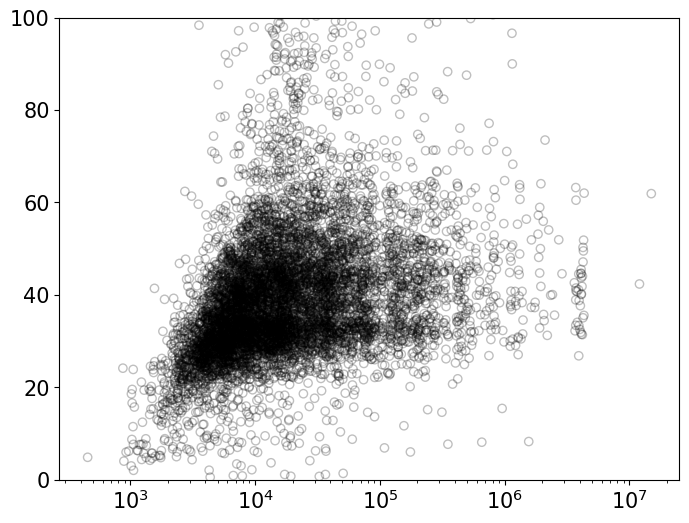

In [20]:
plt.figure(figsize=(8,6))
_  = plt.scatter(data[:,5],data[:,1], marker="o", edgecolor="k", facecolor="None", alpha=0.25)
plt.ylim(0,100)
plt.xscale('log')


In [6]:
data_r = np.load("./improved_output_r.npy")
data_g = np.load("./improved_output_g.npy")
data_i = np.load("./improved_output_i.npy")

##### Plot Everything

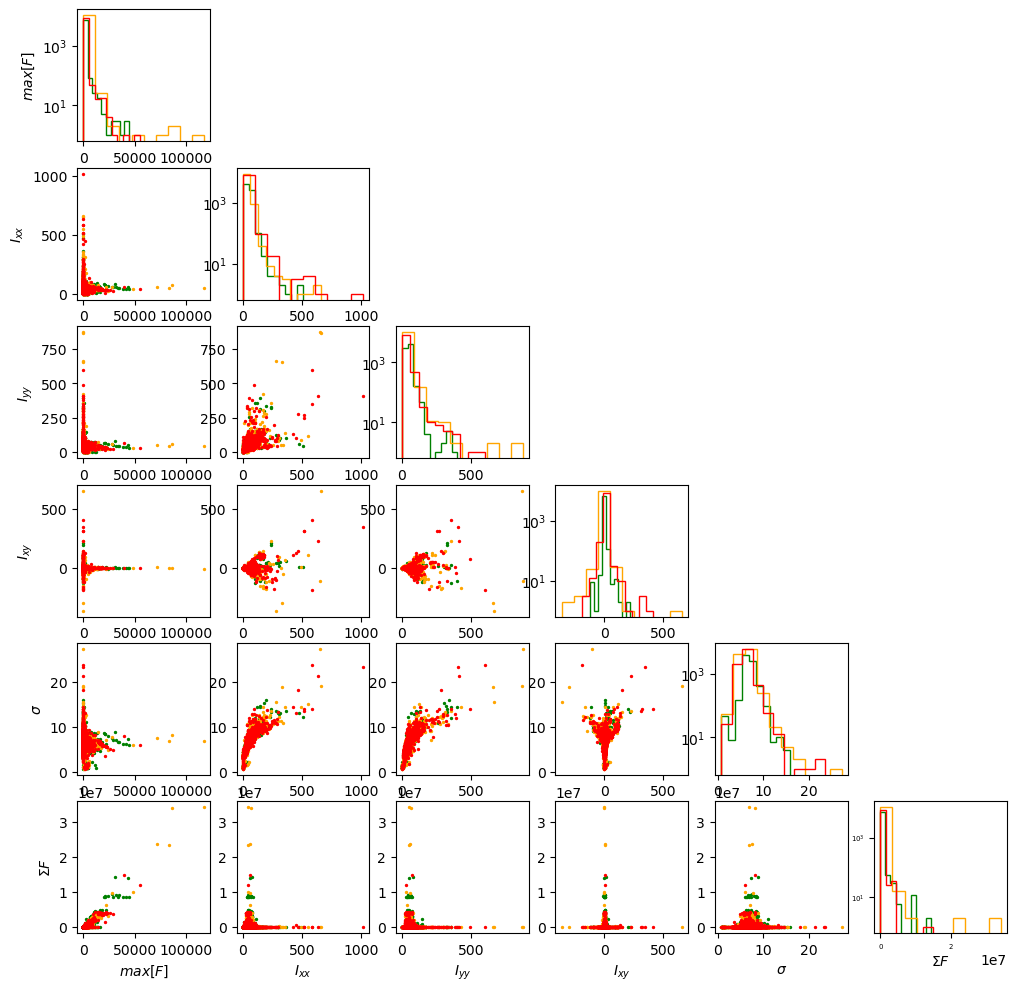

In [8]:
n = 6
import itertools

fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(12,12))

labels = ["$max[F]$","$I_{xx}$","$I_{yy}$","$I_{xy}$","$\sigma$","$\Sigma F$"]
colors=["green", "orange","red"]
for num,result in enumerate([data_g,data_r,data_i]):
    for i in range(n):
        for j in range(n):

            ax = axs[i][j]

            if i < j:
                ax.set_visible(False)

            if i == j:
                _ = ax.hist(result[:,i], color=colors[num],histtype='step')
                ax.set_yscale('log')
            else:
                _ = ax.scatter(result[:,j],result[:,i], marker="o", color=colors[num], s=2)
            plt.xticks(fontsize=5)
            plt.yticks(fontsize=5)
            if i == 5: 
                ax.set_xlabel(labels[j])
            if j == 0:
                ax.set_ylabel(labels[i])
            #ax.set_title(f"({i}, {j})")


g 3.2503730355206237e-07 56.03284698698269 ( 5.510504081133606e-07 )
r 5.08640039876827e-07 45.939979169062184 ( 2.383750191103998e-07 )
i -2.2290000214949771e-07 45.30666005726127 ( 7.196152342424846e-07 )


(-100.0, 300.0)

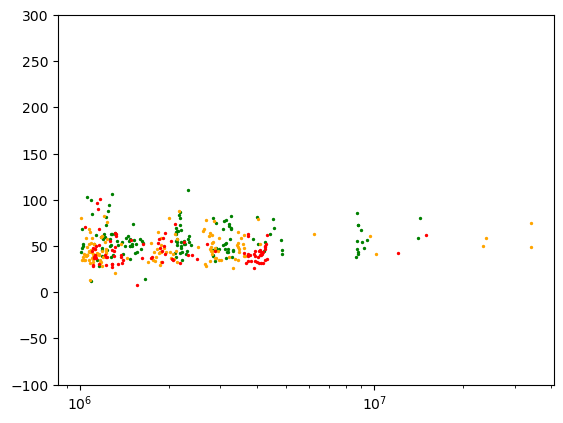

In [24]:
bands = ['g','r','i']
for num,result in enumerate([data_g,data_r,data_i]):
    mask = (result[:,5] > 1e6) * (result[:,1] < 200.)
    _ = plt.scatter(result[:,5][mask],result[:,1][mask], marker="o", color=colors[num], s=2)
    (m,b),cov = np.polyfit(result[:,5][mask],result[:,1][mask],deg=1,cov=True)
    print(bands[num],m,b, "(",np.sqrt(cov[0][0]),")")
plt.xscale('log')
plt.ylim(-100,300)